<a href="https://colab.research.google.com/github/tozanni/airhacking_ddmty2019/blob/master/AirHacking_DDMTY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import json


## Análisis de Datos de calidad del Aire usando Python

Eduardo H. Ramirez (eduardo@ensitech.com)



### 1. Referencia del listado de campos

https://docs.google.com/document/d/15ijz94dXJ-YAZLi9iZ_RaBwrZ4KtYeCy08goGBwnbCU/edit


### 2. Leer PurpleAir.json

Es necesario entrar al mapa ( https://www.purpleair.com/map?mylocation ) y usar el inspector de Chrome para obtener el ID del sensor (json?show=ID)


![title](https://raw.githubusercontent.com/tozanni/airhacking_ddmty2019/master/obtener-json.png)

In [0]:
j = pd.read_json("https://www.purpleair.com/json?show=31843")


In [3]:
j

,mapVersion,baseVersion,mapVersionString,results
0,0.2,7,,"{'ID': 31843, 'Label': 'Nuevo Sur', 'DEVICE_LO..."
1,0.2,7,,"{'ID': 31844, 'ParentID': 31843, 'Label': 'Nue..."


Los resultados vienen por duplicados ya que cada equipo tiene dos sensores por redundancia. 

Posteriormente, cada sensor tiene dos canales de datos (Primary y Secondary), esto por limitaciones del API de Thingspeak.

Nos interesa principalmente obtener los siguientes datos:

- **THINGSPEAK_PRIMARY_ID**: ID del canal primario de datos.
 
- **THINGSPEAK_PRIMARY_ID_READ_KEY**: Llave de lectura para Thingspeak


In [4]:
# Sensor primario
j.loc[0]["results"]

{'AGE': 1,
 'Adc': '0.02',
 'Created': 1557767298,
 'DEVICE_BRIGHTNESS': '15',
 'DEVICE_HARDWAREDISCOVERED': '2.0+BME280+PMSX003-B+PMSX003-A',
 'DEVICE_LOCATIONTYPE': 'outside',
 'Hidden': 'false',
 'ID': 31843,
 'Label': 'Nuevo Sur',
 'LastSeen': 1573621163,
 'LastUpdateCheck': 1573618282,
 'Lat': 25.652478,
 'Lon': -100.27323,
 'PM2_5Value': '7.01',
 'RSSI': '-67',
 'Stats': '{"v":7.01,"v1":6.81,"v2":7.03,"v3":7.7,"v4":10.94,"v5":19.15,"v6":18.44,"pm":7.01,"lastModified":1573621163846,"timeSinceModified":120062}',
 'THINGSPEAK_PRIMARY_ID': '779958',
 'THINGSPEAK_PRIMARY_ID_READ_KEY': 'I93BJE92YBMDS6D5',
 'THINGSPEAK_SECONDARY_ID': '779959',
 'THINGSPEAK_SECONDARY_ID_READ_KEY': '4GZZP2LIK2X8G5L0',
 'Type': 'PMS5003+PMS5003+BME280',
 'Uptime': '1907399',
 'Version': '4.11',
 'humidity': '47',
 'isOwner': 0,
 'p_0_3_um': '1065.83',
 'p_0_5_um': '308.67',
 'p_10_0_um': '0.01',
 'p_1_0_um': '35.93',
 'p_2_5_um': '1.57',
 'p_5_0_um': '0.01',
 'pm10_0_atm': '7.23',
 'pm10_0_cf_1': '7.23',
 

In [5]:
# Sensor secundario
j.loc[1]["results"]

{'AGE': 1,
 'Adc': '0.02',
 'Created': 1557767298,
 'Hidden': 'false',
 'ID': 31844,
 'Label': 'Nuevo Sur B',
 'LastSeen': 1573621163,
 'Lat': 25.652478,
 'Lon': -100.27323,
 'PM2_5Value': '6.91',
 'ParentID': 31843,
 'Stats': '{"v":6.91,"v1":6.82,"v2":7.02,"v3":7.63,"v4":10.78,"v5":18.87,"v6":17.97,"pm":6.91,"lastModified":1573621163846,"timeSinceModified":120062}',
 'THINGSPEAK_PRIMARY_ID': '779960',
 'THINGSPEAK_PRIMARY_ID_READ_KEY': 'M9S9QIAAXXTM46DW',
 'THINGSPEAK_SECONDARY_ID': '779961',
 'THINGSPEAK_SECONDARY_ID_READ_KEY': '15JY1JNZ57GF8YPT',
 'isOwner': 0,
 'p_0_3_um': '1130.05',
 'p_0_5_um': '315.33',
 'p_10_0_um': '0.0',
 'p_1_0_um': '35.59',
 'p_2_5_um': '1.97',
 'p_5_0_um': '0.47',
 'pm10_0_atm': '7.5',
 'pm10_0_cf_1': '7.5',
 'pm1_0_atm': '5.32',
 'pm1_0_cf_1': '5.32',
 'pm2_5_atm': '6.91',
 'pm2_5_cf_1': '6.91'}

Para verificar la confiabilidad del equipo hay que comparar las lecturas de sus dos sensores internos y validar que sean similares con (Stats)


### Lectura usando el API de Thingspeak

https://thingspeak.readthedocs.io/en/latest/api.html
    

#### Opciones

https://la.mathworks.com/help/thingspeak/readdata.html
    

In [7]:
!pip install thingspeak

In [0]:
import thingspeak


In [0]:
## Obtener el channel ID y read_key del resultado previo

channel_id = j.loc[1]["results"]["THINGSPEAK_PRIMARY_ID"]
read_key = j.loc[1]["results"]["THINGSPEAK_PRIMARY_ID_READ_KEY"]

tz = 'America/Monterrey'

channel = thingspeak.Channel(id=channel_id,api_key=read_key)

# Ultimos 2000 lecturas
#jj = channel.get_field(field='field2', options = {'results': 2000})

## Todas las lecturas en los rangos de fechas especificados
#jj = channel.get_field(field='field2', options = {'start':'2019-05-15T00:00:00Z','end':'2019-05-18T00:00:00Z'})

### Lecturas de PM2.5, del 8 al 29 de Agosto de 2019
jj = channel.get_field(field='field8', options = {'start':'2019-08-25T00:00:00Z',
                                                  'end':'2019-08-29T00:00:00Z',
                                                  #'average':'daily',
                                                  'timezone':tz})


In [10]:
jj

'{"channel":{"id":779960,"name":"AirMonitor_7a75_b","latitude":"0.0","longitude":"0.0","field1":"PM1.0 (ATM)","field2":"PM2.5 (ATM)","field3":"PM10.0 (ATM)","field4":"Mem","field5":"Adc","field6":"Pressure","field7":"Unused","field8":"PM2.5 (CF=1)","created_at":"2019-05-13T12:08:17-05:00","updated_at":"2019-05-13T12:08:17-05:00","last_entry_id":115051},"feeds":[{"created_at":"2019-08-24T19:01:29-05:00","entry_id":58520,"field8":"16.26"},{"created_at":"2019-08-24T19:03:29-05:00","entry_id":58521,"field8":"17.81"},{"created_at":"2019-08-24T19:05:29-05:00","entry_id":58522,"field8":"18.79"},{"created_at":"2019-08-24T19:07:29-05:00","entry_id":58523,"field8":"17.01"},{"created_at":"2019-08-24T19:09:29-05:00","entry_id":58524,"field8":"17.97"},{"created_at":"2019-08-24T19:11:29-05:00","entry_id":58525,"field8":"26.87"},{"created_at":"2019-08-24T19:13:29-05:00","entry_id":58526,"field8":"29.71"},{"created_at":"2019-08-24T19:15:29-05:00","entry_id":58527,"field8":"22.84"},{"created_at":"2019-

In [11]:
json_data = json.loads(jj)
json_data["feeds"]

[{'created_at': '2019-08-24T19:01:29-05:00',
  'entry_id': 58520,
  'field8': '16.26'},
 {'created_at': '2019-08-24T19:03:29-05:00',
  'entry_id': 58521,
  'field8': '17.81'},
 {'created_at': '2019-08-24T19:05:29-05:00',
  'entry_id': 58522,
  'field8': '18.79'},
 {'created_at': '2019-08-24T19:07:29-05:00',
  'entry_id': 58523,
  'field8': '17.01'},
 {'created_at': '2019-08-24T19:09:29-05:00',
  'entry_id': 58524,
  'field8': '17.97'},
 {'created_at': '2019-08-24T19:11:29-05:00',
  'entry_id': 58525,
  'field8': '26.87'},
 {'created_at': '2019-08-24T19:13:29-05:00',
  'entry_id': 58526,
  'field8': '29.71'},
 {'created_at': '2019-08-24T19:15:29-05:00',
  'entry_id': 58527,
  'field8': '22.84'},
 {'created_at': '2019-08-24T19:17:29-05:00',
  'entry_id': 58528,
  'field8': '20.51'},
 {'created_at': '2019-08-24T19:19:29-05:00',
  'entry_id': 58529,
  'field8': '18.79'},
 {'created_at': '2019-08-24T19:21:29-05:00',
  'entry_id': 58530,
  'field8': '21.64'},
 {'created_at': '2019-08-24T19:2

## Creación de dataframe con Pandas con el campo de JSON

- Tomamos el valor del campo created_at como timestamp
- Tomamos el valor de la lectura de field8 (PM2.5)


In [0]:

df = pd.DataFrame.from_dict(json_data["feeds"])

df["datetime"] = pd.to_datetime(df["created_at"])

df.drop(["created_at","entry_id"], axis=1,inplace=True)

df.rename(columns={"field8":"PM2.5_CF_ATM_ug/m3"},inplace=True)

df.set_index("datetime",inplace=True)

#df

In [13]:
df.head()

,PM2.5_CF_ATM_ug/m3
datetime,
2019-08-24 19:01:29-05:00,16.26
2019-08-24 19:03:29-05:00,17.81
2019-08-24 19:05:29-05:00,18.79
2019-08-24 19:07:29-05:00,17.01
2019-08-24 19:09:29-05:00,17.97


## Opción B: Trabajando con archivos descargados desde /sensorlist

Estos archivos pueden obtenerse desde:

https://map.purpleair.org/sensorlist

**OJO:** Es una página MUY lenta (>5min en desplegar)

In [0]:
# Descargar desde Github en modo RAW, funciona para archivos menores a 25MB

df0 = pd.read_csv("https://raw.githubusercontent.com/tozanni/airhacking_ddmty2019/master/LaPastora_Primary_040119_050119.csv")

df1 = pd.read_csv("https://raw.githubusercontent.com/tozanni/airhacking_ddmty2019/master/PrivMontana_Primary_040119_050119.csv")


In [23]:
df0

,created_at,entry_id,PM1.0_CF_ATM_ug/m3,PM2.5_CF_ATM_ug/m3,PM10.0_CF_ATM_ug/m3,UptimeMinutes,RSSI_dbm,Pressure_hpa,--,PM2.5_CF_1_ug/m3,Unnamed: 10
0,2019-04-01 00:00:35 UTC,15123,16.81,23.32,24.02,840.0,-79.0,68.0,45.0,23.32,NaN
1,2019-04-01 00:01:54 UTC,15124,16.00,21.68,22.60,841.0,-79.0,68.0,45.0,21.68,NaN
2,2019-04-01 00:03:14 UTC,15125,15.59,21.77,24.05,843.0,-80.0,68.0,45.0,21.77,NaN
3,2019-04-01 00:04:34 UTC,15126,15.77,21.07,21.43,844.0,-80.0,68.0,45.0,21.07,NaN
4,2019-04-01 00:05:54 UTC,15127,15.30,20.78,21.39,845.0,-80.0,68.0,45.0,20.78,NaN
...,...,...,...,...,...,...,...,...,...,...,...
31303,2019-04-29 23:53:43 UTC,46426,16.68,22.95,23.93,819.0,-78.0,86.0,41.0,22.95,NaN
31304,2019-04-29 23:55:03 UTC,46427,15.58,22.73,23.67,820.0,-82.0,86.0,41.0,22.73,NaN
31305,2019-04-29 23:56:23 UTC,46428,15.26,21.57,22.69,821.0,-82.0,86.0,41.0,21.57,NaN
31306,2019-04-29 23:57:43 UTC,46429,16.28,22.21,22.60,823.0,-81.0,86.0,41.0,22.21,NaN


In [0]:
def prepare(df):
    
    #Eliminar columnas innecesarias
    df.drop("Unnamed: 10", axis=1, inplace=True)
    
    #Conversion de tipo de datos, de momento ignorar el Timezone
    df["datetime"] = pd.to_datetime(df.created_at,  utc=None)
    
    #Eliminar columnas innecesarias
    df.drop(["created_at","entry_id"],axis=1,inplace=True)
    
    #Crear indice en la columna datetime
    df.set_index("datetime",inplace=True)
    
    # Crear una columna por dia (esto no es necesario, lo hacemos a modo de ejemplo)
    df['date'] = df.index.date
    return df

df = prepare(df0)

In [25]:
df[["PM2.5_CF_ATM_ug/m3"]].head()

,PM2.5_CF_ATM_ug/m3
datetime,
2019-04-01 00:00:35+00:00,23.32
2019-04-01 00:01:54+00:00,21.68
2019-04-01 00:03:14+00:00,21.77
2019-04-01 00:04:34+00:00,21.07
2019-04-01 00:05:54+00:00,20.78


In [27]:
df.head()

,PM1.0_CF_ATM_ug/m3,PM2.5_CF_ATM_ug/m3,PM10.0_CF_ATM_ug/m3,UptimeMinutes,RSSI_dbm,Pressure_hpa,--,PM2.5_CF_1_ug/m3,date
datetime,,,,,,,,,
2019-04-01 00:00:35+00:00,16.81,23.32,24.02,840.0,-79.0,68.0,45.0,23.32,2019-04-01
2019-04-01 00:01:54+00:00,16.00,21.68,22.60,841.0,-79.0,68.0,45.0,21.68,2019-04-01
2019-04-01 00:03:14+00:00,15.59,21.77,24.05,843.0,-80.0,68.0,45.0,21.77,2019-04-01
2019-04-01 00:04:34+00:00,15.77,21.07,21.43,844.0,-80.0,68.0,45.0,21.07,2019-04-01
2019-04-01 00:05:54+00:00,15.30,20.78,21.39,845.0,-80.0,68.0,45.0,20.78,2019-04-01


### Cálculo de índices (PM2.5 AQI)


#### 1. Obtener concentraciones promedio diarias (dos métodos)

**Método A. Group-by**

Requiere la creación de una columna auxiliar

In [32]:
# Concentracion promedio diaria (a partir de la serie de minutos)
df[['date','PM2.5_CF_ATM_ug/m3','PM1.0_CF_ATM_ug/m3']].groupby(['date']).mean().head()

,PM2.5_CF_ATM_ug/m3,PM1.0_CF_ATM_ug/m3
date,,
2019-04-01,19.568454,13.328824
2019-04-02,26.977268,18.626608
2019-04-03,54.914115,31.726497
2019-04-04,24.352572,16.150130
2019-04-05,20.767454,14.513759


**Método B. Resample**

La forma más poderosa es usar DataFrame.resample

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html


In [31]:
pm25_daily_avg = df[['date','PM2.5_CF_ATM_ug/m3','PM1.0_CF_ATM_ug/m3']].resample('D').mean()
pm25_daily_avg.head()

,PM2.5_CF_ATM_ug/m3,PM1.0_CF_ATM_ug/m3
datetime,,
2019-04-01 00:00:00+00:00,19.568454,13.328824
2019-04-02 00:00:00+00:00,26.977268,18.626608
2019-04-03 00:00:00+00:00,54.914115,31.726497
2019-04-04 00:00:00+00:00,24.352572,16.150130
2019-04-05 00:00:00+00:00,20.767454,14.513759


/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


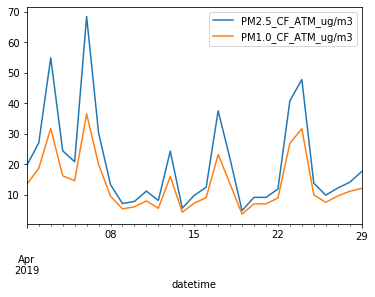

In [34]:
import matplotlib as plt

#pm25_daily_avg
pm25_daily_avg.plot()

In [0]:
# Basadas en el calculo de
# https://airnow.gov/index.cfm?action=airnow.calculator
# PM2.5 es la recomendacion de la OMS

def Linear(AQIhigh, AQIlow, Conchigh, Conclow, Conc):
    a=((Conc-Conclow)/(Conchigh-Conclow))*(AQIhigh-AQIlow)+AQIlow;
    return round(a)

def AQIPM25(Conc):
    import math
    c=(math.floor(10*Conc))/10
    AQI = 0
    
    if (c>=0 and c<12.1):
        AQI=Linear(50,0,12,0,c)
    elif (c>=12.1 and c<35.5):
        AQI=Linear(100,51,35.4,12.1,c)
    elif (c>=35.5 and c<55.5):
        AQI=Linear(150,101,55.4,35.5,c)
    elif (c>=55.5 and c<150.5):
        AQI=Linear(200,151,150.4,55.5,c)
    elif (c>=150.5 and c<250.5):
        AQI=Linear(300,201,250.4,150.5,c)
    elif (c>=250.5 and c<350.5):
        AQI=Linear(400,301,350.4,250.5,c)
    elif (c>=350.5 and c<500.5):
        AQI=Linear(500,401,500.4,350.5,c)
    return AQI

def AQICategory(AQI):
    if (AQI<=50):
        AQICategory="1. Good"
    elif (AQI>50 and AQI<=100):
        AQICategory="2. Moderate"
    elif(AQI>100 and AQI<=150):
        AQICategory="3. Unhealthy for Sensitive Groups"
    elif (AQI>150 and AQI<=200):
        AQICategory="4. Unhealthy"
    elif (AQI>200 and AQI<=300):
        AQICategory="5. Very Unhealthy"
    elif (AQI>300 and AQI<=400):
        AQICategory="6. Hazardous"
    elif (AQI>400 and AQI<=500):
        AQICategory="7. Hazardous"
    else:
        AQICategory="Out of Range"
    
    return AQICategory


def IMECA25(Conc):
    imeca = 0
    
    if (Conc >= 0 and Conc <= 15.4):
        imeca = Conc*50 / 15.4
    elif (Conc >= 15.5 and Conc <= 40.4):
        imeca =  20.50 + Conc*49/24.9
    elif (Conc >= 40.5 and Conc <= 65.4 ):
        imeca =  21.30 + Conc*49/24.9
    elif (Conc >= 65.5 and Conc <= 150.4):
        imeca =  113.20 + Conc*49/84.9
    elif (Conc > 150.4):
        imeca = Conc*201/150.5
    
    return round(imeca)


In [69]:
pm25_daily_avg["AQI2.5"] = pm25_daily_avg["PM2.5_CF_ATM_ug/m3"].apply(AQIPM25)

pm25_daily_avg["IMECA2.5"] = pm25_daily_avg["PM2.5_CF_ATM_ug/m3"].apply(IMECA25)

pm25_daily_avg.head()

,PM2.5_CF_ATM_ug/m3,PM1.0_CF_ATM_ug/m3,AQI2.5,IMECA2.5,AQI_PM2.5_Cat
datetime,,,,,
2019-04-01 00:00:00+00:00,19.568454,13.328824,67,59,Moderate
2019-04-02 00:00:00+00:00,26.977268,18.626608,82,74,Moderate
2019-04-03 00:00:00+00:00,54.914115,31.726497,149,129,Unhealthy for Sensitive Groups
2019-04-04 00:00:00+00:00,24.352572,16.150130,77,68,Moderate
2019-04-05 00:00:00+00:00,20.767454,14.513759,69,61,Moderate


### ¿Cuántos días hay por cada categoría de AQI / IMECA?

In [70]:
pm25_daily_avg["AQI_PM2.5_Cat"]  = pm25_daily_avg["AQI2.5"].apply(AQICategory)

pm25_daily_avg.groupby("AQI_PM2.5_Cat").count()

,PM2.5_CF_ATM_ug/m3,PM1.0_CF_ATM_ug/m3,AQI2.5,IMECA2.5
AQI_PM2.5_Cat,,,,
1. Good,11,11,11,11
2. Moderate,13,13,13,13
3. Unhealthy for Sensitive Groups,4,4,4,4
4. Unhealthy,1,1,1,1


#### Calcular la concentración promedio por hora del dia

Deseamos saber a qué hora del día hubo menor calidad del aire. Aquí combinamos el uso de resample y group.

In [41]:
pm25_hr_avg = df[['date','PM2.5_CF_ATM_ug/m3','PM1.0_CF_ATM_ug/m3']].resample('h').mean()
pm25_hr_avg.head()

,PM2.5_CF_ATM_ug/m3,PM1.0_CF_ATM_ug/m3
datetime,,
2019-04-01 00:00:00+00:00,21.677556,15.734000
2019-04-01 01:00:00+00:00,22.856222,16.546889
2019-04-01 02:00:00+00:00,17.768889,13.264222
2019-04-01 03:00:00+00:00,12.354889,9.377556
2019-04-01 04:00:00+00:00,8.559778,6.564667


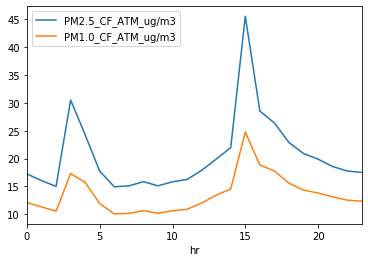

In [42]:
pm25_hr_avg['hr'] = pm25_hr_avg.index.hour
pm25_hr_avg.groupby('hr').mean().plot()


### ¿Cuántos minutos al dia hemos pasado por arriba de una concentracion dada?

**OJO:** Los intervalos de muestreo no son exactamente iguales

In [0]:
#df[['date','PM2.5_CF_ATM_ug/m3']][df['PM2.5_CF_ATM_ug/m3'] > 40]

df[['date','PM2.5_CF_ATM_ug/m3']][df['PM2.5_CF_ATM_ug/m3'] > 40].groupby(['date']).count()


,PM2.5_CF_ATM_ug/m3
date,
2019-04-01,618
2019-04-02,895
2019-04-03,520
2019-04-04,211
2019-04-05,62
2019-04-06,242
2019-04-07,473
2019-04-08,2
2019-04-09,2


In [0]:
#pm25_day_avg = df[['date','PM2.5_CF_ATM_ug/m3']][df['PM2.5_CF_ATM_ug/m3'] > 40].groupby(['date']).count()

#pm25_day_avg = df[['date','PM2.5_CF_ATM_ug/m3']].groupby(['date']).mean()

#!pip install seaborn

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

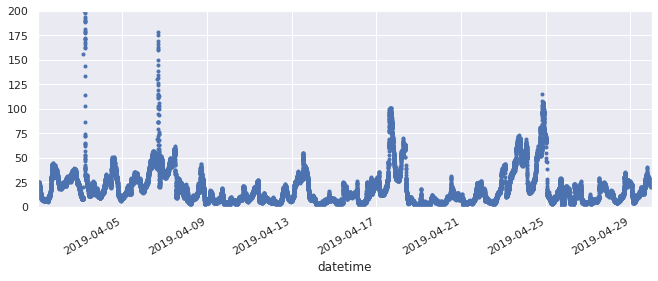

In [49]:
sns.set(rc={'figure.figsize':(11, 4)})
df['PM2.5_CF_ATM_ug/m3'].plot(marker=".",linewidth=0.5,ylim=(0,200),linestyle='None');

#pm25_day_avg['PM2.5_CF_ATM_ug/m3'].plot(marker=".",linewidth=0.5);

### ¿Cuáles son las variaciones por día de la semana?

In [0]:
#df['Weekday'] = df.index.weekday
#sns.boxplot(data=df.loc['2019-04-15':'2019-04-30'], x='Weekday', y='PM2.5_CF_ATM_ug/m3');
#TODO: Existen outliers en los primeros días del mes, posibles fuentes locales?

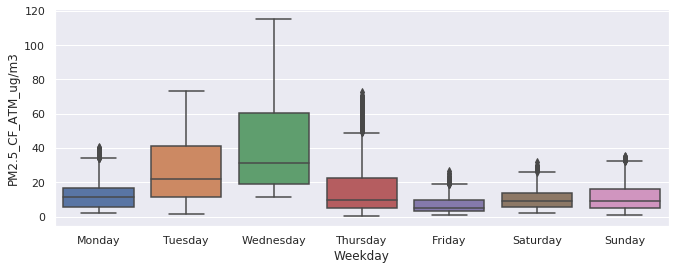

In [64]:
df['Weekday'] = df.index.weekday_name
sns.boxplot(data=df.loc['2019-04-15':'2019-04-30'], x='Weekday', y='PM2.5_CF_ATM_ug/m3');


## ¿Por qué necesitamos reporteo en promedios menores de 24 horas?

In [71]:
data_columns = ['PM2.5_CF_ATM_ug/m3']

df_daily_mean = df[data_columns].resample('D').mean()

df_4hr_mean = df[data_columns].resample('4H').mean()

df_4hr_mean.head()

,PM2.5_CF_ATM_ug/m3
datetime,
2019-04-01 00:00:00+00:00,18.664389
2019-04-01 04:00:00+00:00,7.761722
2019-04-01 08:00:00+00:00,6.599667
2019-04-01 12:00:00+00:00,16.698833
2019-04-01 16:00:00+00:00,36.615611


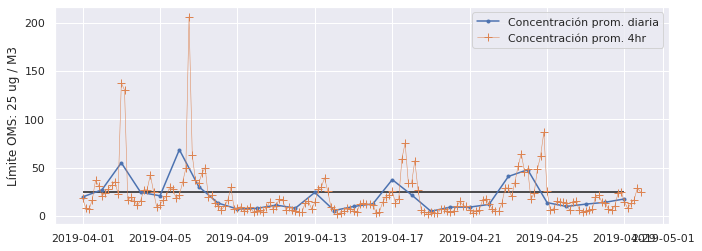

In [77]:
start, end = '2019-04', '2019-05'

df_daily_mean.loc[start]
fig, ax = plt.subplots()

ax.hlines(25,pd.to_datetime('2019-04-01'),pd.to_datetime('2019-04-29'))

ax.plot(df_daily_mean.loc[start:end, data_columns[0]], marker='.', linestyle='-', label='Concentración prom. diaria')

ax.plot(df_4hr_mean.loc[start:end, data_columns[0]], marker='+', markersize=8, linewidth=0.5, linestyle='-', label='Concentración prom. 4hr')

ax.set_ylabel('Límite OMS: 25 ug / M3')

ax.legend();


## Práctica: ¿Cuántos períodos de 4 horas hubo en cada categoría?

In [74]:

#df_4hr_mean.apply

df_4hr_mean["AQI2.5"] = df_4hr_mean["PM2.5_CF_ATM_ug/m3"].apply(AQIPM25)

#df_4hr_mean["AQI2.5_Cat"] = 

,PM2.5_CF_ATM_ug/m3,AQI2.5
datetime,,
2019-04-01 00:00:00+00:00,18.664389,65
2019-04-01 04:00:00+00:00,7.761722,32
2019-04-01 08:00:00+00:00,6.599667,27
2019-04-01 12:00:00+00:00,16.698833,60
2019-04-01 16:00:00+00:00,36.615611,104
...,...,...
2019-04-29 04:00:00+00:00,7.784222,32
2019-04-29 08:00:00+00:00,12.866500,52
2019-04-29 12:00:00+00:00,16.858944,61
